# Importing library

In [6]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np

# Pre prosessing data

In [7]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read the dataset
df_lonely1 = pd.read_csv('/content/drive/MyDrive/testing/clean data/Copy of clean_lonely_2019.csv')
df_lonely2 = pd.read_csv('/content/drive/MyDrive/testing/clean data/Copy of clean_lonely_post.csv')
df_normal = pd.read_csv('/content/drive/MyDrive/testing/clean data/Copy of clean_normal.csv')
df_depp1 = pd.read_csv('/content/drive/MyDrive/testing/clean data/Copy of dep19_no_pun_low.csv')
df_depp2 = pd.read_csv('/content/drive/MyDrive/testing/clean data/Copy of dep_no_pun_low.csv')
df_anx1 = pd.read_csv('/content/drive/MyDrive/testing/clean data/Copy of preprocessed_anxiety_2018.csv')
df_anx2 = pd.read_csv('/content/drive/MyDrive/testing/clean data/Copy of preprocessed_anxiety_post.csv')

FileNotFoundError: ignored

In [ ]:
#Take only 1000 row from all file so we have equal data (except normal)
df_lonely1 = df_lonely1.sample(n=2000,replace=False)
df_lonely2 = df_lonely2.sample(n=2000,replace=False)
df_depp1 = df_depp1.sample(n=2000,replace=False)
df_depp2 = df_depp2.sample(n=2000,replace=False) 
df_anx1 = df_anx1.sample(n=2000,replace=False) 
df_anx2 = df_anx2.sample(n=2000,replace=False)
df_normal = df_normal.sample(n=4000,replace=False)

NameError: ignored

In [ ]:
print(df_lonely1)
print(df_lonely2)
print(df_depp1)
print(df_depp2)
print(df_anx1)
print(df_anx1)
print(df_normal)

NameError: ignored

In [ ]:
#combining data
combined_df = pd.concat([df_lonely1,df_lonely2,df_depp1,df_depp2,df_anx1,df_anx2,df_normal])

In [ ]:
print(combined_df)

       Unnamed: 0 subreddit                                               post
2380         2380    lonely  highschool sucks know write mind racing though...
656           656    lonely  having troubles finding partner hey guys year ...
256           256    lonely  join discord family trying new faces discord s...
678           678    lonely  absurdity billion people world subreddit peopl...
1925         1925    lonely  feel lonely strong real life want online besti...
...           ...       ...                                                ...
11597       11597    normal  driven house theater sweltering heat pleased r...
4585         4585    normal  great ideas life couldnt submit cared notebook...
2442         2442    normal  idea whats idea im gonna mercy shouldve picked...
2416         2416    normal  fuck life dont know im typing advice ive seein...
6953         6953    normal  favorite hartley movies bad bit religious thin...

[16000 rows x 3 columns]


In [ ]:
combined_df['post'] = combined_df['post'].astype(str)

# Split Data

In [ ]:
#Load the dataset
texts = combined_df['post'].tolist()  # Input text
labels = combined_df['subreddit'].tolist()  # Non-binary output labels

In [ ]:
#  Split the dataset into training and testing sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
labels_train = label_encoder.fit_transform(labels_train)
labels_test = label_encoder.transform(labels_test)

In [ ]:
print(f"Training sentences: {len(texts_train)} \n")
print(f"Training labels: {len(texts_test)}\n")

Training sentences: 12800 

Training labels: 3200



In [ ]:
#print(labels_train)
print(label_encoder.inverse_transform([i for i in range(0,4)]))

['anxiety' 'depression' 'lonely' 'normal']


# Tokenization Sequences

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts_train)

In [ ]:
# Convert text to sequences
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

In [ ]:
# Pad sequences to a fixed length
max_sequence_length = max([len(sequence) for sequence in sequences_train])
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length,truncating="post")
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length,truncating="post")


# Embedding

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Define path to file containing the embeddings
GLOVE_FILE = '/content/drive/MyDrive/testing/glove.twitter.27B/glove.twitter.27B.25d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [ ]:
EMBEDDING_DIM = 25
word_index = tokenizer.word_index
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((vocab_size+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

# Defining Model

In [ ]:
# Define the LSTM model
model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM,weights=[EMBEDDINGS_MATRIX], trainable=False), 
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(padded_sequences_train, labels_train, validation_data=(padded_sequences_test, labels_test), epochs=20, batch_size=32)


Epoch 1/20
400/400 [==============================] - 31s 50ms/step - loss: 1.1204 - accuracy: 0.4858 - val_loss: 0.9778 - val_accuracy: 0.5663
Epoch 2/20
400/400 [==============================] - 19s 48ms/step - loss: 0.9308 - accuracy: 0.6005 - val_loss: 0.8985 - val_accuracy: 0.6191
Epoch 3/20
400/400 [==============================] - 18s 46ms/step - loss: 0.8714 - accuracy: 0.6359 - val_loss: 0.8620 - val_accuracy: 0.6431
Epoch 4/20
400/400 [==============================] - 20s 51ms/step - loss: 0.8245 - accuracy: 0.6631 - val_loss: 0.8229 - val_accuracy: 0.6531
Epoch 5/20
400/400 [==============================] - 18s 45ms/step - loss: 0.7913 - accuracy: 0.6743 - val_loss: 0.8307 - val_accuracy: 0.6506
Epoch 6/20
400/400 [==============================] - 19s 48ms/step - loss: 0.7554 - accuracy: 0.6940 - val_loss: 0.7597 - val_accuracy: 0.6906
Epoch 7/20
400/400 [==============================] - 18s 46ms/step - loss: 0.7217 - accuracy: 0.7096 - val_loss: 0.7309 - val_accuracy:

# Evaluate Model

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(padded_sequences_test, labels_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

100/100 [==============================] - 2s 21ms/step - loss: 0.6053 - accuracy: 0.7713
Test Loss: 0.6052770018577576
Test Accuracy: 0.7712500095367432


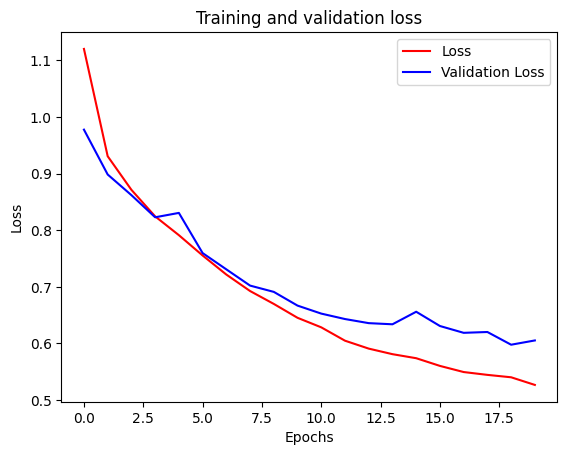

In [ ]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

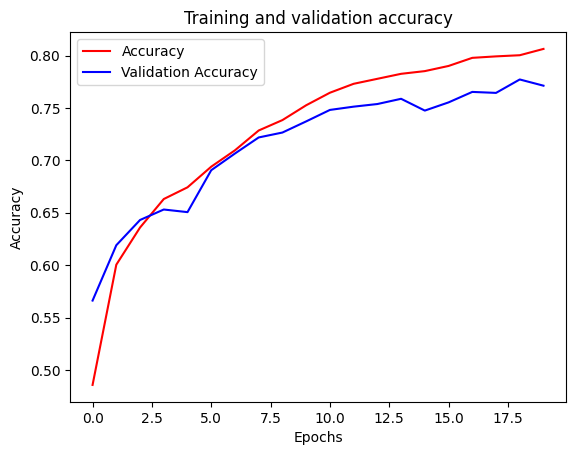

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

# Save a Model

In [ ]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/PROJECT/Model/saved_model')

In [ ]:
# saving a tokenizer
with open('/content/drive/MyDrive/PROJECT/Model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Using a Saved Model

In [8]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/PROJECT/Model/saved_model')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          938375    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               5376      
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 944,939
Trainable params: 6,564
Non-trainable params: 938,375
______________________________________________

In [15]:
with open('/content/drive/MyDrive/PROJECT/Model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [11]:
seed_text = '''like taking long walks snows quieter  '''
#'''Does anyone else like taking long walks while it snows? Everything is quieter.  '''
token_list = tokenizer.texts_to_sequences([seed_text])[0]
#Pad the sequences
token_list = pad_sequences([token_list],padding='post')
# Get the probabilities of predicting a word
predicted = new_model.predict(token_list, verbose=0)[0]
print('probabilitas : ');
print('Anxiety : {:.2%}'.format(predicted[0]))
print('Depresi : {:.2%}'.format(predicted[1]))
print('Lonely : {:.2%}'.format(predicted[2]))
print('Normal : {:.2%}'.format(predicted[3]))

probabilitas : 
Anxiety : 43.98%
Depresi : 20.18%
Lonely : 27.29%
Normal : 8.54%


# Save Model to .h5 format

In [12]:
tf.keras.models.save_model(new_model, '/content/drive/MyDrive/PROJECT/Model/saved_model.h5')

## Load model from .h5 Format

In [13]:
saved_model_h5 = tf.keras.models.load_model('/content/drive/MyDrive/PROJECT/Model/saved_model.h5')

In [14]:
saved_model_h5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          938375    
                                                                 
 bidirectional (Bidirectiona  (None, 32)               5376      
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 944,939
Trainable params: 6,564
Non-trainable params: 938,375
______________________________________________

In [16]:
seed_text = '''like taking long walks snows quieter  '''
#'''Does anyone else like taking long walks while it snows? Everything is quieter.  '''
token_list = tokenizer.texts_to_sequences([seed_text])[0]
#Pad the sequences
token_list = pad_sequences([token_list],padding='post')
# Get the probabilities of predicting a word
predicted = saved_model_h5.predict(token_list, verbose=0)[0]
print('probabilitas : ');
print('Anxiety : {:.2%}'.format(predicted[0]))
print('Depresi : {:.2%}'.format(predicted[1]))
print('Lonely : {:.2%}'.format(predicted[2]))
print('Normal : {:.2%}'.format(predicted[3]))

probabilitas : 
Anxiety : 43.98%
Depresi : 20.18%
Lonely : 27.29%
Normal : 8.54%
